In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import glob, pdb, os, sys, cv2
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import networkx as nx

import matplotlib.cm as cm
from PIL import Image

from itertools import combinations
import pickle
import os
from pathlib import Path


In [2]:
def enhance_for_loops(A):
    # Assuming binary_matrix is your binary image (numpy array)
    # For demonstration, let's create a random binary matrix
    binary_matrix = A.N.T.astype(np.uint8) * 255  # Convert to 8-bit format with 0 and 255
    

    # Define a kernel for dilation (structuring element)
    kernel_size = 2  # You can adjust this size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply dilation
    dilated_image = cv2.dilate(binary_matrix, kernel, iterations=1)
    
    kernel_size = kernel_size-1  # You can adjust this size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
    
    # kernel_size = 1 # You can adjust this size
    # kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # final_image = cv2.dilate(eroded_image, kernel, iterations=1)
    final_image = eroded_image.copy()
    return final_image    
    
    
    # # Display the original and dilated images
    # plt.figure(figsize=(10, 10))
    
    # plt.subplot(1, 3, 1)
    # plt.title('Original Binary Image')
    # plt.imshow(binary_matrix, cmap='gray')
    
    # plt.subplot(1, 3, 2)
    # plt.title('Dilated Image')
    # plt.imshow(dilated_image, cmap='gray')
    
    # plt.subplot(1, 3, 3)
    # plt.title('Eroded Image')
    # plt.imshow(eroded_image, cmap='gray')
    
    # plt.show()


In [3]:
def map_to_square(arr,dest):
    # Find the minimum and maximum values for each column (x and y coordinates)
    min_vals = arr.min(axis=0)
    max_vals = arr.max(axis=0)
    
    # Normalize the coordinates to [0, 1]
    norm_arr = (arr - min_vals) / (max_vals - min_vals)
    
    # Scale and shift to [-1, 1]
    shift = dest -np.array([1,0])
    scaled_arr = norm_arr * 2 +shift
    
    return scaled_arr


# Step 1: Skeletonize the Image
def skeletonize_image(image):
    # return skeletonize(binary_image // 255
    return skeletonize(image).astype(np.uint8)

# Step 2: Detect Nodes and Edges
def detect_nodes_edges(skeleton):
    # Identify all nodes
    # Use a connectivity-8 kernel to find nodes
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)
    convolved = cv2.filter2D(skeleton, -1, kernel)
    
    nodes = np.where((convolved > 10) & (convolved < 18))
    
    return list(zip(nodes[1], nodes[0]))


# Step 3: Create a Graph
def create_graph(skeleton, nodes):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    
    for node in nodes:
        x, y = node
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                if skeleton[y + dy, x + dx] == 1:
                    neighbor = (x + dx, y + dy)
                    if neighbor in nodes:
                        G.add_edge(node, neighbor)
    
    return transform_graph(G)


def transform_graph(original_graph):
    '''
    The graph by turning the image directly to a graph is formed by considering each pixel of the network
    as a node and definig the edges in a good way. This function transforms it to a simpler graph, where
    the whole line between two junction nodes are considered to be edges. This helps with faster computation
    '''
    new_graph = nx.Graph()
    
    # Find nodes to retain (degree != 2)
    nodes_to_retain = [node for node, degree in original_graph.degree() if degree != 2]
    
    # Keep track of visited nodes to avoid revisiting
    visited = set()
    
    for node in nodes_to_retain:
        visited.add(node)
        for neighbor in original_graph.neighbors(node):
            if neighbor not in visited:
                path = [node]
                current = neighbor
                
                # Follow the path of degree-2 nodes
                while original_graph.degree(current) == 2:
                    next_node = next(n for n in original_graph.neighbors(current) if n != path[-1])
                    path.append(current)
                    current = next_node
                
                # Add the final node of the path
                path.append(current)
                
                # Add the new edge to the new graph
                # if len(path) == 2:
                #     path = np.array(path)
                #     if np.linalg.norm(path[1]-path[0]) == np.sqrt(2):
                #         continue
                if len(path) > 1:
                    new_graph.add_node(node)
                    new_graph.add_node(current)
                    new_graph.add_edge(node, current, weight=np.array(path))

    new_graph = remove_edges_with_conditions(new_graph)
    return new_graph

def remove_edges_with_conditions(G):
    '''
    This function removes some of the redundent edges in the graph simplification process
    '''
    edges_to_remove = []

    for u, v, data in G.edges(data=True):
        # Check if both endpoint nodes have degree 3
        if G.degree[u] >= 3 and G.degree[v] >= 3:
            # Check if there is at least one common neighbor
            common_neighbors = set(G.neighbors(u)).intersection(set(G.neighbors(v)))
            if common_neighbors:
                curve = data.get('weight', None)
                
                # Check if the curve is a 2x2 matrix
                if curve is not None and len(curve) == 2 and len(curve[0]) == 2:
                    curve_array = np.array(curve)
                    
                    # Check if the distance between start and end points is sqrt(2)
                    start_point, end_point = curve_array[0], curve_array[1]
                    distance = np.linalg.norm(end_point - start_point)
                    if np.isclose(distance, np.sqrt(2)):
                        edges_to_remove.append((u, v))
    
    # Remove the edges
    G.remove_edges_from(edges_to_remove)
    return G


In [4]:

# Step 4: Find Cycles
def convertCycleToCurve(graph,cycles):
    cyclesList = []
    for cycle in cycles:
        curveList = []
        for i in range(len(cycle)-1):
            n_1 = cycle[i]
            n_2 = cycle[i+1]
            if graph.get_edge_data(n_1,n_2) is not None:
                curveList.append(graph.get_edge_data(n_1,n_2)["weight"])
        if graph.get_edge_data(cycle[-1],cycle[0]) is not None:
            curveList.append(graph.get_edge_data(cycle[-1],cycle[0])["weight"])
        cyclesList.append(curveList)

    return cyclesList


# Visualize the basis and merged cycles
def visualize_cycles(image, cyclesList, mergedCycles):
    fig = plt.figure()
    plt.imshow(image, cmap='gray')
    for cycle in cyclesList:
        for curve in cycle:
            plt.plot(curve[:,0],curve[:,1],'r-')

    colors = ['lime', 'cyan', 'magenta', 'yellow', 'orange', 'red', 'blue', 'green', 'purple', 'pink']
    ii=0
    for cycle in mergedCycles:
        for curve in cycle:
            # plt.plot(curve[:,0],curve[:,1],color='lime')
            plt.plot(curve[:,0],curve[:,1], color=colors[ii%10])
        ii+=1

    return fig


# Detect and plot cycles
def detectLoops(image, plot=True, skeletonize=False, merge_cycles=False):
    if skeletonize:
        skeleton = skeletonize_image(image)
    else:
        skeleton = image

    nodes = detect_nodes_edges(skeleton)
    graph = create_graph(skeleton, nodes)

    # CyclesList is a list of cycles where each cycle is a list of curves (n*2)
    # basisCycle is a list of cycles where each cycle is the list of its nodes
    
    # basis_cycles = list(nx.cycle_basis(graph))
    # basis_cycles_curve = convertCycleToCurve(graph,basis_cycles)  
    
    
    # Filter and close cycles
    # basis_cycles = [sublist for sublist in cycles_unfiltered if len(sublist) >= 5]
    # for cycle in basis_cycles:
    #     cycle.append(cycle[0])  # Close the cycle

    # Merge overlapping cycles
    # merged_cycles = []
    # if merge_cycles == True:
    #     merged_cycles = find_combined_cycles(basis_cycles)
    #     merged_cycles_curve = convertCycleToCurve(graph,merged_cycles)  
    # else:
    #     merged_cycles_curve = []
    
    # print(f"Detected {len(basis_cycles)} basis cycles in the image.")
    # print(f"Detected {len(merged_cycles)} merged cycles in the image.")

    # if plot:
    #     fig = visualize_cycles(skeleton, basis_cycles_curve, [merged_cycles_curve[i] for i in [1,3,6,8]])
    # else:
    #     fig = None
    
    # return skeleton, basis_cycles_curve, merged_cycles_curve, graph, fig
    print("Graph Generated!")
    return skeleton, graph



def find_combined_cycles(basis_cycles):

    # Convert each cycle to a set of edges
    basis_edge_sets = [set(tuple(sorted((u, v))) for u, v in zip(cycle, cycle[1:] + [cycle[0]])) for cycle in basis_cycles]

    combined_cycles = []

    # Check combinations of cycles
    for cycle1, cycle2 in combinations(basis_edge_sets, 2):
        # Compute the symmetric difference
        symmetric_diff = cycle1.symmetric_difference(cycle2)

        # Check if the cycles are not disjoint and not identical
        if cycle1 & cycle2 and symmetric_diff:
            combined_cycles.append(symmetric_diff)

    # Convert the edge sets back to node cycles
    def edges_to_cycle(edges):
        graph = nx.Graph()
        graph.add_edges_from(edges)
        return list(nx.cycle_basis(graph))

    all_combined_cycles = []
    for edge_set in combined_cycles:
        all_combined_cycles.extend(edges_to_cycle(edge_set))

    return all_combined_cycles


def normalize_cycle(cycle):
    """
    Normalize a cycle to fit in a 1x1 square [0, 1] x [0, 1].
    """
    min_vals = np.min(cycle, axis=0)
    max_vals = np.max(cycle, axis=0)
    return (cycle - min_vals) / (max_vals - min_vals)

def plot_cycles_in_grid(cyclesList):
    num_cycles = len(cyclesList)
    grid_size = int(np.ceil(np.sqrt(num_cycles)))  # Grid dimensions (square grid)
    
    # fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size , grid_size ))
    axes = axes.flatten()  # Flatten axes array for easy indexing
    
    for i, cycle in enumerate(cyclesList):
        ax = axes[i]
        cycle = np.array(cycle)
        normalized_cycle = normalize_cycle(cycle)  # Normalize cycle to [0, 1] x [0, 1]
        # ax.plot(normalized_cycle[:, 0], normalized_cycle[:, 1], marker='o')
        ax.plot(normalized_cycle[:, 0], normalized_cycle[:, 1])
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')  # Turn off axes for better visualization

    # Hide any unused subplots
    for j in range(num_cycles, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [11]:
def process_image_to_graph(image_path, graph_save_path):
    # Read and process the image
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    image = (binary_image // 255).astype(np.uint8)
    image = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    padded_image = cv2.copyMakeBorder(image, 3, 3, 3, 3, cv2.BORDER_CONSTANT, value=0)

    # Generate the skeleton and graph
    skeleton, graph = detectLoops(padded_image, skeletonize=True, merge_cycles=True, plot=False)

    # Save the graph
    graph_save_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
    with open(graph_save_path, "wb") as f:
        pickle.dump(graph, f)

    print(f"Processed and saved graph: {graph_save_path}")


In [15]:
baseAddress = Path("HRF_DataSet/healthy_manualsegm/")
graphBaseAddress = Path("GraphDataSet/" + "HRF_DataSet/healthy_manualsegm/")

for item in baseAddress.iterdir():
    # if item.is_file() and item.suffix == ".png":  # Process only .tif files
    if item.is_file() and item.suffix == ".tif":  # Process only .tif files
        # Construct the corresponding path in graphBaseAddress
        relative_path = item.relative_to(baseAddress)
        graph_save_path = graphBaseAddress / relative_path.with_suffix(".gpickle")

        # Process and save the graph
        process_image_to_graph(item, graph_save_path)
    elif item.is_dir():
        print(f"Directory: {item}")

Graph Generated!
Processed and saved graph: GraphDataSet/HRF_DataSet/healthy_manualsegm/07_h.gpickle
Graph Generated!
Processed and saved graph: GraphDataSet/HRF_DataSet/healthy_manualsegm/04_h.gpickle
Graph Generated!
Processed and saved graph: GraphDataSet/HRF_DataSet/healthy_manualsegm/02_h.gpickle
Graph Generated!
Processed and saved graph: GraphDataSet/HRF_DataSet/healthy_manualsegm/11_h.gpickle
Graph Generated!
Processed and saved graph: GraphDataSet/HRF_DataSet/healthy_manualsegm/13_h.gpickle
Graph Generated!
Processed and saved graph: GraphDataSet/HRF_DataSet/healthy_manualsegm/14_h.gpickle
Graph Generated!
Processed and saved graph: GraphDataSet/HRF_DataSet/healthy_manualsegm/08_h.gpickle
Graph Generated!
Processed and saved graph: GraphDataSet/HRF_DataSet/healthy_manualsegm/09_h.gpickle
Graph Generated!
Processed and saved graph: GraphDataSet/HRF_DataSet/healthy_manualsegm/06_h.gpickle
Graph Generated!
Processed and saved graph: GraphDataSet/HRF_DataSet/healthy_manualsegm/15_

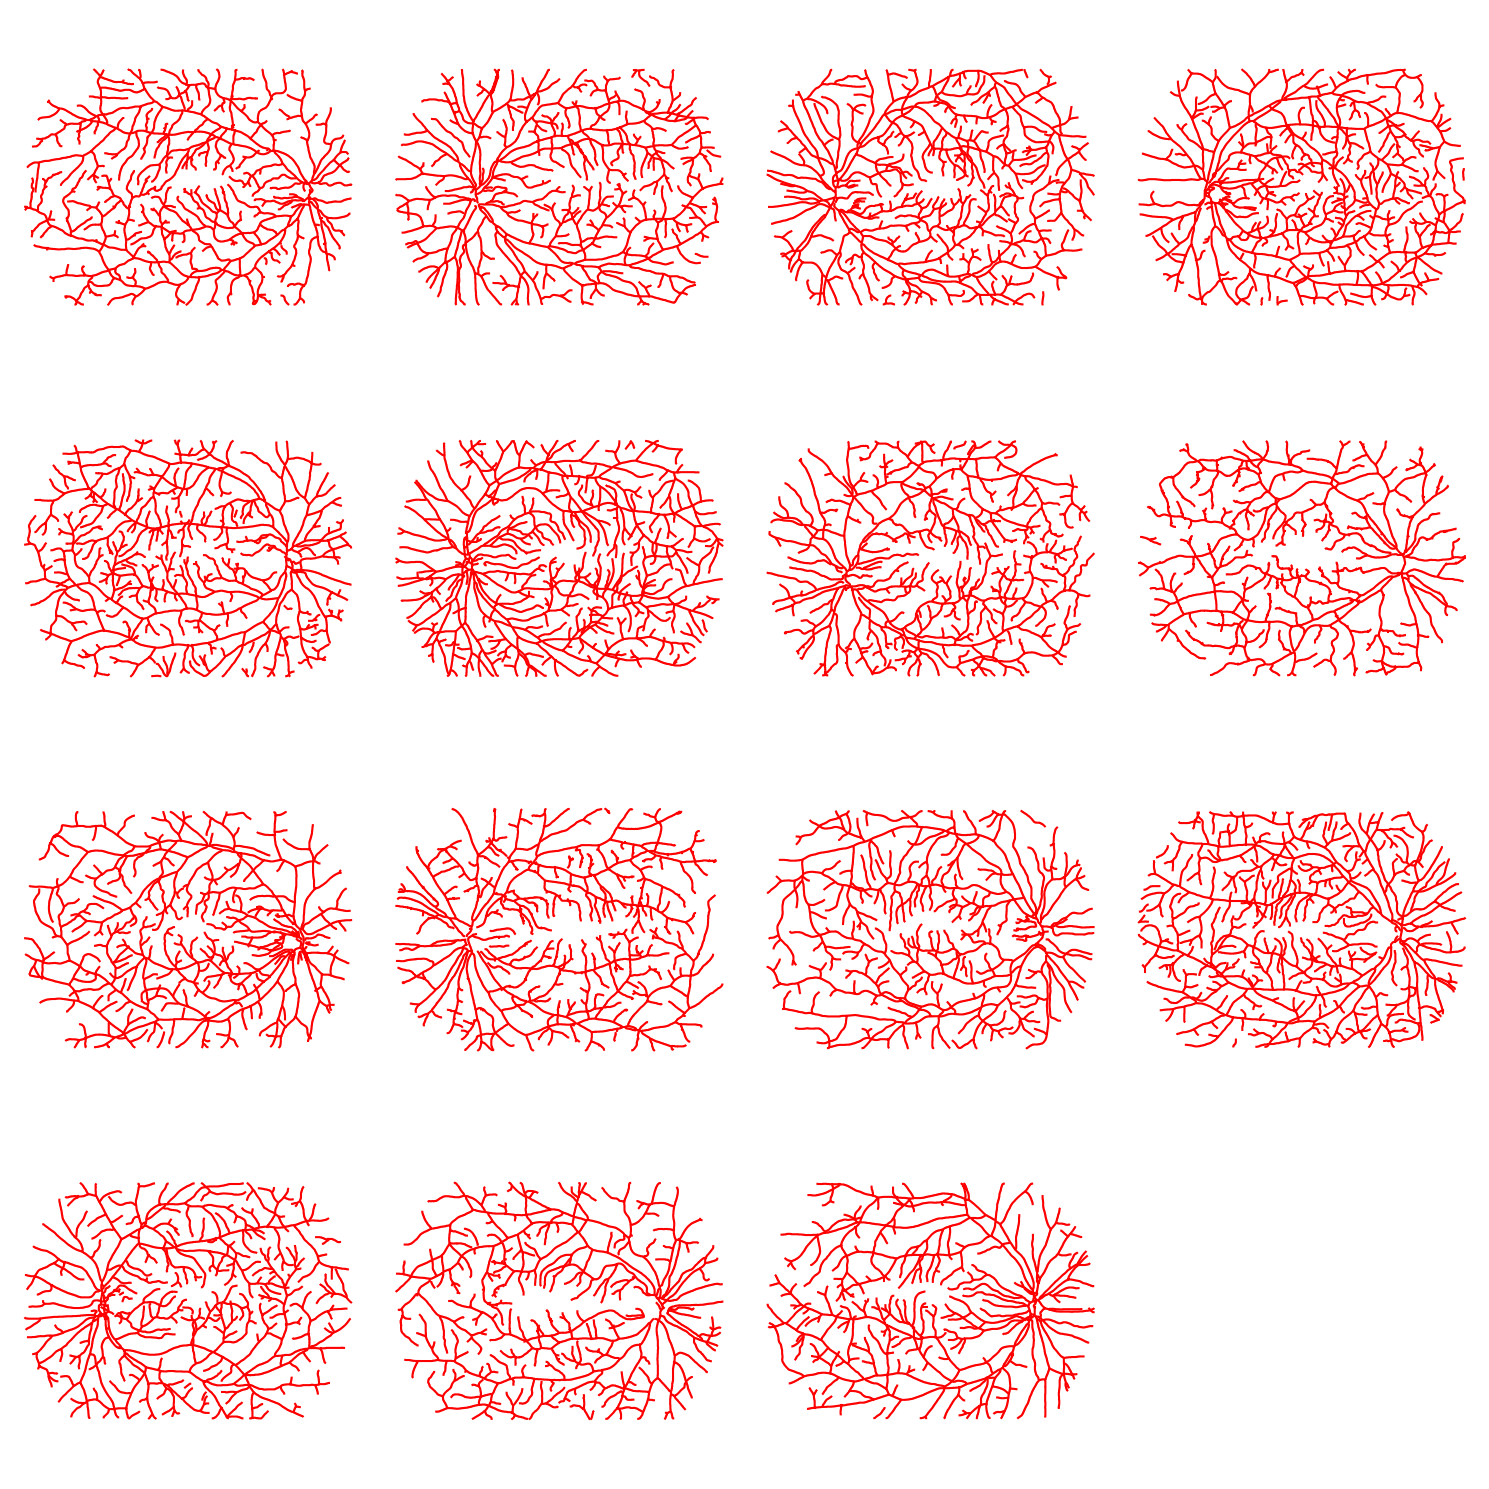

In [16]:
gpickle_files = list(graphBaseAddress.rglob("*.gpickle"))

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()  # Flatten the axes array for easier indexing

for idx, ax in enumerate(axes[:25]):  # Loop through the first 25 subplots
    if idx < len(gpickle_files):  # Ensure we don't exceed the number of files
        try:
            # Load the graph
            with open(gpickle_files[idx], "rb") as f:
                loaded_graph = pickle.load(f)

            # Plot each graph
            for u, v, data in loaded_graph.edges(data=True):
                curve = np.array(data["weight"])
                ax.plot(curve[:, 0], curve[:, 1], "r-")

            # ax.set_title(gpickle_files[idx].name)  # Add a title for each subplot
            ax.axis("equal")  # Equal aspect ratio
            ax.axis("off")  # Turn off axes for cleaner plots

        except Exception as e:
            print(f"Error loading or plotting graph {gpickle_files[idx]}: {e}")
            ax.set_title("Error")
            ax.axis("off")
    else:
        ax.axis("off")  # Turn off unused subplots

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [17]:
# fig.savefig("HRF-healthy.png")